# Calculating Extreme Heat days using daily projections from Cal-Adapt API

This notebook walks you through how we calculate projected Extreme Heat Days for an area.

### Step 1. Download data
 - Download observed daily maximum temperatures for an area or grid cell.
 - Download projected daily maximum temperatures for the location. We will use the 4 priority models and RCP 8.5 scenario (HadGEM2-ES, CNRM-CM5, CanESM2, MIROC5 models have been selected by [California’s Climate Action Team Research Working Group](http://climatechange.ca.gov/climate_action_team/research.html) as [priority models for research](http://docketpublic.energy.ca.gov/PublicDocuments/16-IEPR-04/TN215798_20170207T111409_Projected_Climate_Scenarios_Selected_to_Represent_a_Range_of_Po.pdf) contributing to California’s Fourth Climate Change Assessment).
 
### Step 2. Calculate Extreme Heat Threshold
 - Using a baseline period of 1961 - 1990, calculate the 98th percentile value of all temperatures from April - October from the observed data.
 - This 98th percentile value is the Extreme Heat Threshold for that location (note: different locations will have different values for extreme heat threshold). If you want to find all days above a cutoff threshold temperature, e.g. 100F, you can skip this step. 

### Step 3. Calculate number of extreme heat days
 - Find all days with maximum temperatures above threshold from observed and projected data.
 
### Step 4. Report projected Extreme heat days
 - For reporting projected Extreme Heat day counts we reccommend using decadal or multi-decadal averages for future time periods.
 
### Step 5. Calculate and Report Heat Waves
 
You can modify this approach for your needs.

In [1]:
# A 'magic' command to display plots inline
%matplotlib inline

# Import all python modules. You need to run this cell for the other cells to work.
import requests 
import numpy as np
import pandas as pd
from datetime import datetime
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

----
## Step 1. Download data
----

### 1a. Defining your area of interest

The `g` geometry parameter is used to download data for a point, line or polygon. Geometry can be written in various formats including WKT, GeoJSON, KML. The examples below use WKT (Well Known Text) format.

#### To get data for a grid cell ...

In [14]:
point = 'POINT(-121.4687 38.5938)'

#### To get data for a user defined polygon ...

You can create a new polygon using this [online WKT editor](https://arthur-e.github.io/Wicket/sandbox-gmaps3.html) or any GIS software.

In [15]:
polygon = 'POLYGON ((-123.35449 39.09596, -122.27783 39.09596, -122.27783 39.97712, -123.35449 39.97712, -123.35449 39.09596))' 

#### Or select a polygon from boundaries stored on Cal-Adapt

To use polygon geometry from Cal-Adapt API, it's a 2-step process

- Query a Cal-Adapt API boundary layer ([list of available boundaries](https://berkeley-gif.github.io/caladapt-docs/data-catalog.html#vector-data)) using a point to get the intersecting polygon
- Instead of passing the geometry using the `g` parameter, use the `ref` parameter to use geometry stored on server 

**Note: Requests might time out if the polygon is too large. If you need to spatially aggregate daily data for extreme heat calculations, the data provider reccomends doing that at a scale of census tracts, city boundaries or small watershed boundaries (e.g. HUC10). If you need to process data for several boundaries we reccomend downloading the daily rasters and processing the data locally.** 

In [16]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'

# Name of boundary layer in API (Census Tracts)
resource = 'censustracts'

#Get ID
url = api + '/' + resource + '/?intersects=' +  point

response = requests.get(url)
county = response.json()
county = county['features'][0]
id  = county['id']
id

5074

### 1b. Download observed daily tasmax

Daily data is stored as a multiband raster, e.g. observed daily timeseries (1950 -2013) has 23376 bands with each band corresponding to one day, starting from 1950-01-01. Units for the observed data are degrees Celsius and projected data are in Kelvin.

The code in the next cell contains a bunch of functions to:
    - fetch daily data given an ID and params
    - return a new Pandas dataframe that contains all the data

In [84]:
# Cal-Adapt API
api = 'http://api.cal-adapt.org/api'
# Request header
headers = {'ContentType': 'json'}

def process_daily_data(slug):
    # Make request
    url = api + '/series/' + slug + '/events/?ref=/api/censustracts/%s/&imperial=TRUE&stat=mean' % id
    response = requests.get(url)
    #print(response)
    # Get data
    if response.ok:
        data = response.json()
        df = pd.DataFrame(data)
        df.set_index('index', inplace = True)
        df.index = pd.to_datetime(df.index)
    
    else:
        print('Failed to download:')
    return df

url = api + '/series/' + 'tasmax_day_livneh' + '/events/?ref=/api/censustracts/%s/&imperial=TRUE&stat=mean' % id
response = requests.get(url)
print(response)
    # Get data
if response.ok:
    data = response.json()
    df = pd.DataFrame(data)
    df.set_index('index', inplace = True)
    df.index = pd.to_datetime(df.index)  
else:
    print('Failed to download:')
#print(df)

In [80]:
def get_observed():
    # Create slug
    slug = 'tasmax_day_livneh'
    df = process_daily_data(slug)
    return df

In [81]:
observedDF = get_observed()
observedDF

                                        name       data
index                                                  
1950-01-01 00:00:00+00:00  tasmax_day_livneh  44.473999
1950-01-02 00:00:00+00:00  tasmax_day_livneh  40.784000
1950-01-03 00:00:00+00:00  tasmax_day_livneh  47.794998
1950-01-04 00:00:00+00:00  tasmax_day_livneh  43.844002
1950-01-05 00:00:00+00:00  tasmax_day_livneh  45.095001
1950-01-06 00:00:00+00:00  tasmax_day_livneh  49.099998
1950-01-07 00:00:00+00:00  tasmax_day_livneh  50.926998
1950-01-08 00:00:00+00:00  tasmax_day_livneh  48.820999
1950-01-09 00:00:00+00:00  tasmax_day_livneh  51.116001
1950-01-10 00:00:00+00:00  tasmax_day_livneh  49.099998
1950-01-11 00:00:00+00:00  tasmax_day_livneh  48.019997
1950-01-12 00:00:00+00:00  tasmax_day_livneh  51.485001
1950-01-13 00:00:00+00:00  tasmax_day_livneh  44.105000
1950-01-14 00:00:00+00:00  tasmax_day_livneh  44.348000
1950-01-15 00:00:00+00:00  tasmax_day_livneh  49.558998
1950-01-16 00:00:00+00:00  tasmax_day_livneh  42

,name,data
index,,
1950-01-01 00:00:00+00:00,tasmax_day_livneh,44.473999
1950-01-02 00:00:00+00:00,tasmax_day_livneh,40.784000
1950-01-03 00:00:00+00:00,tasmax_day_livneh,47.794998
1950-01-04 00:00:00+00:00,tasmax_day_livneh,43.844002
1950-01-05 00:00:00+00:00,tasmax_day_livneh,45.095001
1950-01-06 00:00:00+00:00,tasmax_day_livneh,49.099998
1950-01-07 00:00:00+00:00,tasmax_day_livneh,50.926998
1950-01-08 00:00:00+00:00,tasmax_day_livneh,48.820999
1950-01-09 00:00:00+00:00,tasmax_day_livneh,51.116001


### 1c. Download projected daily tasmax

The projected daily timeseries are form 2006 - 2099/2100 and units are in degrees Kelvin. You can easily modify the code to add/subtract models, scenarios, climate variables

In [85]:
def get_projections():
    # Create an empty list to hold dataframes
    df_list = []

    # Make a combined list of GCMs, scenarios, climate variables for looping
    climvar = ['tasmax']
    period = ['day']
    models = ['CanESM2', 'CNRM-CM5', 'HadGEM2-ES', 'MIROC5']
    #scenarios = ['rcp45', 'rcp85', 'historical]
    scenarios = ['rcp45', 'historical']
    zipped = itertools.product(climvar, period, models, scenarios)

    # Loop through zipped
    for item in zipped:
        # Create slug
        slug = '_'.join(item)
        df = process_daily_data(slug)
        df_list.append(df)
            
    # Combine all the dataframes into one and return
    return pd.concat(df_list)

In [86]:
projectedDF = get_projections()
projectedDF

,name,data
index,,
2006-01-01 00:00:00+00:00,tasmax_day_CanESM2_rcp45,45.031597
2006-01-02 00:00:00+00:00,tasmax_day_CanESM2_rcp45,42.887505
2006-01-03 00:00:00+00:00,tasmax_day_CanESM2_rcp45,46.136932
2006-01-04 00:00:00+00:00,tasmax_day_CanESM2_rcp45,46.308868
2006-01-05 00:00:00+00:00,tasmax_day_CanESM2_rcp45,49.453705
2006-01-06 00:00:00+00:00,tasmax_day_CanESM2_rcp45,49.817459
2006-01-07 00:00:00+00:00,tasmax_day_CanESM2_rcp45,48.961845
2006-01-08 00:00:00+00:00,tasmax_day_CanESM2_rcp45,42.878609
2006-01-09 00:00:00+00:00,tasmax_day_CanESM2_rcp45,48.186321


----
## Step 2. Calculate Extreme Heat threshold
----

For the Cal-Adapt Extreme Heat Tool, default Extreme Heat Threshold is the 98th percentile of historical maximum temperatures between April 1 and October 31 based on observed daily temperature data from 1961–1990. If you want to use a different cutoff temperature you can skip this step.

In [87]:
# Filter data by baseline time period
baselineDF = observedDF.loc['1961-01-01':'1990-12-31']

# Filter data by warm months
baselineDF = baselineDF[(baselineDF.index.month >= 4) & (baselineDF.index.month <= 10)]

print(baselineDF.head())
print()
print(baselineDF.tail())

                                        name       data
index                                                  
1961-04-01 00:00:00+00:00  tasmax_day_livneh  76.748001
1961-04-02 00:00:00+00:00  tasmax_day_livneh  82.561996
1961-04-03 00:00:00+00:00  tasmax_day_livneh  85.414993
1961-04-04 00:00:00+00:00  tasmax_day_livneh  81.347000
1961-04-05 00:00:00+00:00  tasmax_day_livneh  79.942993

                                        name       data
index                                                  
1990-10-27 00:00:00+00:00  tasmax_day_livneh  83.776993
1990-10-28 00:00:00+00:00  tasmax_day_livneh  81.211998
1990-10-29 00:00:00+00:00  tasmax_day_livneh  75.352997
1990-10-30 00:00:00+00:00  tasmax_day_livneh  72.509003
1990-10-31 00:00:00+00:00  tasmax_day_livneh  71.024002


In [88]:
threshold = baselineDF['data'].quantile(0.98, interpolation='linear')
print('Extreme Heat Threshold value for', location, 'is', round(threshold, 1), 'degrees Fahrenheit')

Extreme Heat Threshold value for Census Tract ID 6067006900 is 104.0 degrees Fahrenheit


----

## Step 3. Calculate number of extreme heat days
----

### 3a.  Find days above threshold from observed data

In [90]:
# Filter days > threshold
observed_heat_days = pd.DataFrame(observedDF[observedDF.data > threshold])
observed_heat_days['series'] = 'livneh'
observed_heat_days.index.name = 'date'
observed_heat_days = observed_heat_days.drop(['name'], axis=1)

print(observed_heat_days.head())
print()
print(observed_heat_days.tail())

                                 data  series
date                                         
1950-06-29 00:00:00+00:00  106.258995  livneh
1950-06-30 00:00:00+00:00  108.275002  livneh
1950-07-01 00:00:00+00:00  109.336990  livneh
1950-07-02 00:00:00+00:00  108.175995  livneh
1950-08-17 00:00:00+00:00  104.108002  livneh

                                 data  series
date                                         
2013-06-29 00:00:00+00:00  106.736000  livneh
2013-06-30 00:00:00+00:00  105.494003  livneh
2013-07-01 00:00:00+00:00  105.034996  livneh
2013-07-03 00:00:00+00:00  104.584999  livneh
2013-07-04 00:00:00+00:00  108.049995  livneh


### 3b. Find days above threshold from projected data

In [94]:
# Filter days > threshold
projected_heat_days = pd.DataFrame(projectedDF[projectedDF.data > threshold])
projected_heat_days['series'] = projected_heat_days['name'].str.split('_', expand=True)[2]
projected_heat_days.index.name = 'date'
projected_heat_days = projected_heat_days.drop(['name'], axis=1)

print(projected_heat_days.head())
print()
print(projected_heat_days.tail())

                                 data   series
date                                          
2006-05-29 00:00:00+00:00  105.551376  CanESM2
2006-05-30 00:00:00+00:00  105.704361  CanESM2
2006-06-25 00:00:00+00:00  107.705963  CanESM2
2006-06-26 00:00:00+00:00  105.881355  CanESM2
2006-06-27 00:00:00+00:00  104.994865  CanESM2

                                 data  series
date                                         
2003-08-03 00:00:00+00:00  107.479866  MIROC5
2003-08-04 00:00:00+00:00  106.709938  MIROC5
2003-08-05 00:00:00+00:00  104.189674  MIROC5
2005-07-27 00:00:00+00:00  105.110550  MIROC5
2005-07-29 00:00:00+00:00  104.352768  MIROC5


----
## Step 4.  Report projected Extreme heat days
----

### 4a. Number of extreme heat days by year from observed data, averaged over 1961-1990

In [96]:
# Filter dates by baseline time period
baseline_heat_days = observed_heat_days.loc['1961-01-01':'1990-12-31']
# Group by year and calculate mean
count = baseline_heat_days.data.resample('1AS').count().mean()
print('Historically (1961-1990)', location, 'County had an average of', int(count), 'days with daily highs above', round(threshold, 1), 'degrees F')

Historically (1961-1990) Census Tract ID 6067006900 County had an average of 4 days with daily highs above 104.0 degrees F


### 4b. Number of extreme heat days by year from HadGEM2-ES RCP 4.5, averaged over 2070-2099

In [97]:
# Filter dates by end of century time period
century_end_heat_days = projected_heat_days.loc['2070-01-01':'2099-12-31']

TypeError: Cannot compare tz-naive and tz-aware datetime-like objects

In [98]:
heat_days = century_end_heat_days.loc[century_end_heat_days['series'] == 'HadGEM2-ES']
count = heat_days.value.resample('1AS').count().mean()
print('If current emission trends peak around 2040 and then decline (RCP 4.5)', location, 'will have an average of', int(count), 'days with daily highs above', round(threshold, 1), 'degrees F by end of century (2070-2099) under simulated warmer/drier conditions (HadGEM2-ES)')

NameError: name 'century_end_heat_days' is not defined

### 4c. Plot Number of Extreme Heat Days by Year

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


Text(0, 0.5, 'Number of Extreme Heat Days by Year')

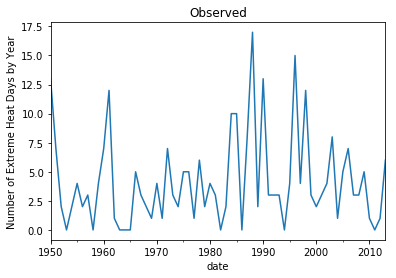

In [100]:
observed_count_by_year = observed_heat_days.data.resample('1AS').count()

# Plot
observed_count_by_year.plot()
plt.title("Observed")
plt.ylabel("Number of Extreme Heat Days by Year")

In [101]:
projected_count_by_year = projected_heat_days.groupby(['series']).data.resample('1AS').count().unstack('series')
projected_count_by_year

series,CNRM-CM5,CanESM2,HadGEM2-ES,MIROC5
date,,,,
1950-01-01 00:00:00+00:00,3.0,2.0,2.0,3.0
1951-01-01 00:00:00+00:00,3.0,6.0,5.0,10.0
1952-01-01 00:00:00+00:00,3.0,3.0,2.0,3.0
1953-01-01 00:00:00+00:00,5.0,4.0,10.0,3.0
1954-01-01 00:00:00+00:00,5.0,4.0,2.0,13.0
1955-01-01 00:00:00+00:00,4.0,7.0,1.0,5.0
1956-01-01 00:00:00+00:00,10.0,1.0,12.0,3.0
1957-01-01 00:00:00+00:00,1.0,1.0,12.0,7.0
1958-01-01 00:00:00+00:00,0.0,5.0,2.0,4.0


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


Text(0, 0.5, 'Number of Extreme Heat Days by Year')

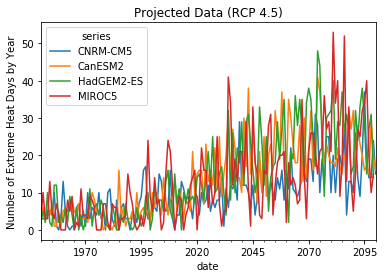

In [103]:
# Plot
projected_count_by_year.plot()
plt.title("Projected Data (RCP 4.5)")
plt.ylabel("Number of Extreme Heat Days by Year")


### 4d. Heatmap of Timing of Extreme Heat Days

In [104]:
months_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
              7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

In [107]:
observed_count_by_month = pd.DataFrame(observed_heat_days.data.resample('M').count())
observed_count_by_month['month'] = observed_count_by_month.index.month
observed_count_by_month['year'] = observed_count_by_month.index.year
observed_count_by_month.rename(columns={'data': 'count'}, inplace=True)
#observed_count_by_month
observed_count_by_month_pivot = observed_count_by_month.pivot(index='month', columns='year', values='count')
observed_count_by_month_pivot.sort_index(ascending=False, inplace=True)
observed_count_by_month_pivot.fillna(0, inplace=True)
observed_count_by_month_pivot

year,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,...,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013
month,,,,,,,,,,,,,,,,,,,,,
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
7,2.0,4.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,4.0,6.0,2.0,2.0,3.0,0.0,0.0,0.0,3.0
6,2.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


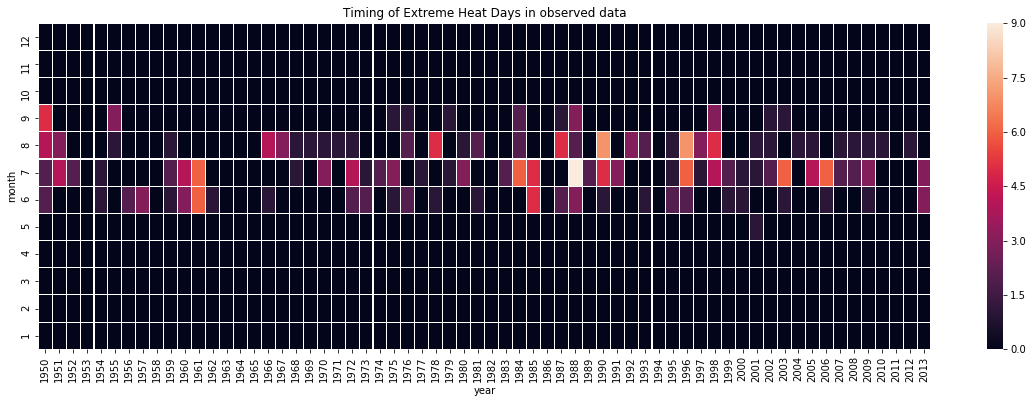

In [108]:
plt.figure(figsize=(20,6))
ax = sns.heatmap(observed_count_by_month_pivot, linewidth=0.1)
plt.title("Timing of Extreme Heat Days in observed data")
plt.show()

In [110]:
projected_count_by_month = projected_heat_days.groupby(['series']).data.resample('M').count().unstack('series')
projected_count_by_month['month'] = projected_count_by_month.index.month
projected_count_by_month['year'] = projected_count_by_month.index.year
projected_count_by_month.fillna(0, inplace=True)
projected_count_by_month

series,CNRM-CM5,CanESM2,HadGEM2-ES,MIROC5,month,year
date,,,,,,
1950-06-30 00:00:00+00:00,1.0,0.0,0.0,0.0,6,1950
1950-07-31 00:00:00+00:00,0.0,0.0,0.0,3.0,7,1950
1950-08-31 00:00:00+00:00,2.0,2.0,2.0,0.0,8,1950
1950-09-30 00:00:00+00:00,0.0,0.0,0.0,0.0,9,1950
1950-10-31 00:00:00+00:00,0.0,0.0,0.0,0.0,10,1950
1950-11-30 00:00:00+00:00,0.0,0.0,0.0,0.0,11,1950
1950-12-31 00:00:00+00:00,0.0,0.0,0.0,0.0,12,1950
1951-01-31 00:00:00+00:00,0.0,0.0,0.0,0.0,1,1951
1951-02-28 00:00:00+00:00,0.0,0.0,0.0,0.0,2,1951


In [111]:
cool_wet = projected_count_by_month.pivot(index='month', columns='year', values='CNRM-CM5').sort_index(ascending=False)
hot_dry = projected_count_by_month.pivot(index='month', columns='year', values='HadGEM2-ES').sort_index(ascending=False)
average = projected_count_by_month.pivot(index='month', columns='year', values='CanESM2').sort_index(ascending=False)
complement = projected_count_by_month.pivot(index='month', columns='year', values='MIROC5').sort_index(ascending=False)

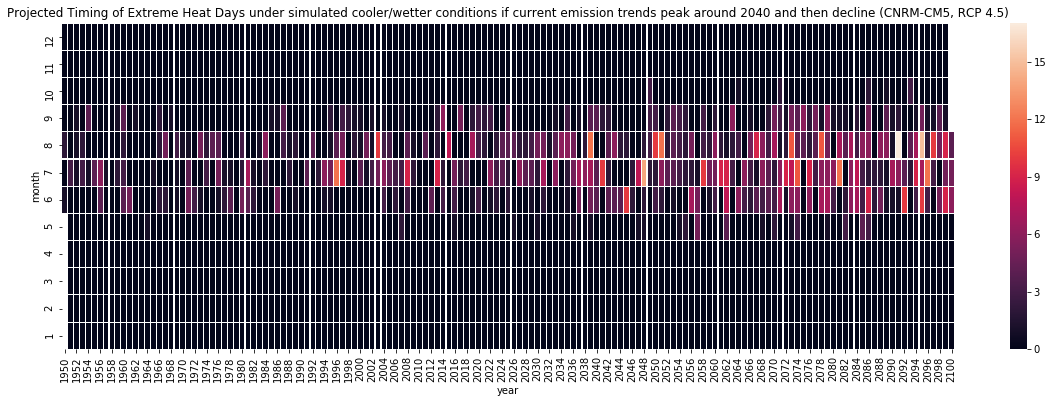

In [112]:
plt.figure(figsize=(20,6))
ax = sns.heatmap(cool_wet, linewidth=0.1)
plt.title("Projected Timing of Extreme Heat Days under simulated cooler/wetter conditions if current emission trends peak around 2040 and then decline (CNRM-CM5, RCP 4.5)")
plt.show()

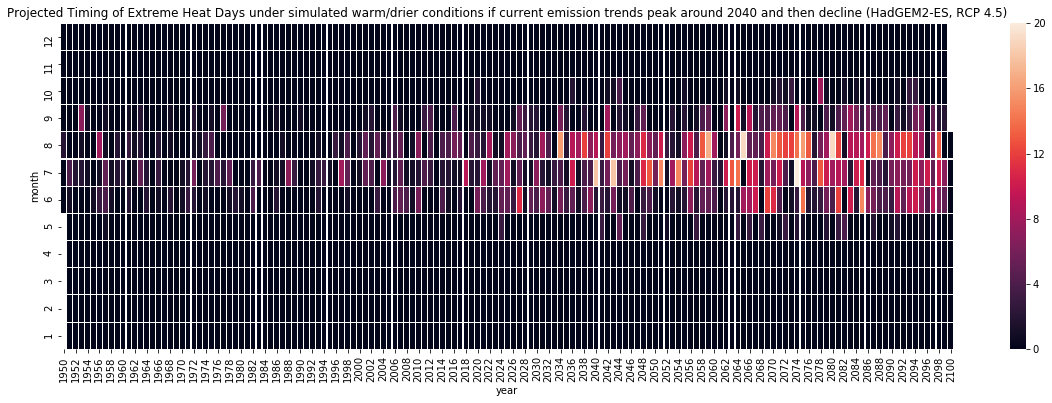

In [113]:
plt.figure(figsize=(20,6))
ax = sns.heatmap(hot_dry, linewidth=0.1)
plt.title("Projected Timing of Extreme Heat Days under simulated warm/drier conditions if current emission trends peak around 2040 and then decline (HadGEM2-ES, RCP 4.5)")
plt.show()

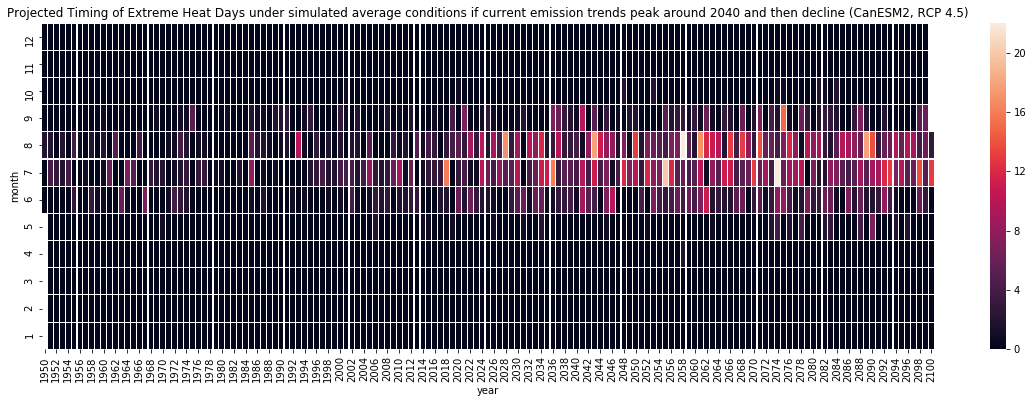

In [114]:
plt.figure(figsize=(20,6))
ax = sns.heatmap(average, linewidth=0.1)
plt.title("Projected Timing of Extreme Heat Days under simulated average conditions if current emission trends peak around 2040 and then decline (CanESM2, RCP 4.5)")
plt.show()

### 4e. Extreme Heat Days by Decade

In [115]:
observed_count_by_decade = pd.DataFrame(observed_heat_days.data.resample('1AS').count())
observed_count_by_decade = observed_count_by_decade.reset_index()
observed_count_by_decade['decade'] = observed_count_by_decade['date'].apply(lambda x: x.year//10*10)
observed_count_by_decade = observed_count_by_decade.groupby(['decade'])['data'].agg(['mean', 'min']).reset_index()
observed_count_by_decade['series'] = 'livneh'
observed_count_by_decade

,decade,mean,min,series
0,1950,3.7,0,livneh
1,1960,3.1,0,livneh
2,1970,3.6,1,livneh
3,1980,5.6,0,livneh
4,1990,6.0,0,livneh
5,2000,4.1,1,livneh
6,2010,2.0,0,livneh


In [116]:
projected_count_by_decade = pd.DataFrame(projected_heat_days.groupby(['series']).data.resample('1AS').count())
projected_count_by_decade = projected_count_by_decade.reset_index()
projected_count_by_decade['decade'] = projected_count_by_decade['date'].apply(lambda x: x.year//10*10)
projected_count_by_decade = projected_count_by_decade.groupby(['series', 'decade'])['data'].agg(['mean']).reset_index()
projected_count_by_decade

,series,decade,mean
0,CNRM-CM5,1950,3.7
1,CNRM-CM5,1960,4.0
2,CNRM-CM5,1970,4.7
3,CNRM-CM5,1980,5.3
4,CNRM-CM5,1990,6.5
5,CNRM-CM5,2000,8.2
6,CNRM-CM5,2010,6.9
7,CNRM-CM5,2020,7.7
8,CNRM-CM5,2030,11.3
9,CNRM-CM5,2040,10.7


In [117]:
decade = pd.concat([observed_count_by_decade, projected_count_by_decade])
decade = decade.drop(decade[(decade['series'] == 'livneh') & (decade['decade'] == 2010)].index)
decade = decade.drop(decade[(decade['series'] != 'livneh') & (decade['decade'] == 2000)].index)
decade = decade.drop(decade[(decade['series'] != 'livneh') & (decade['decade'] == 2100)].index)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


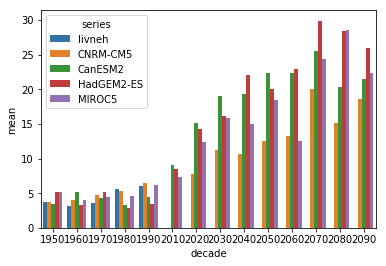

In [118]:
ax = sns.barplot(x='decade', y='mean', hue='series', data=decade)

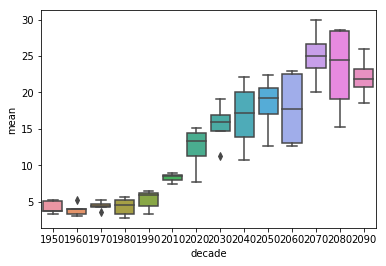

In [119]:
ax = sns.boxplot(x='decade', y='mean', data=decade)

----
## Step 5. Heat Waves
----

### 5a. Calculate Heat Waves

In [120]:
# This function takes a list of (date, value) tuples and groups consecutive dates together into lists
# Returns a list of lists

def parse_date_ranges(dates):

    def group_consecutive(dates):
        #dates_iter = iter(sorted(set(dates)))  # de-dup and sort
        dates_iter = iter(dates);

        run = [next(dates_iter)]
        for d in dates_iter:
            if (d[0].toordinal() - run[-1][0].toordinal()) == 1:  # consecutive?
                run.append(d)
            else:  # [start, end] of range else singleton
                yield [i for i in run]
                run = [d]

        #yield [run[0], run[-1]] if len(run) > 1 else run[0]
        yield [i for i in run]

    return list(group_consecutive(dates)) if dates else False

In [121]:
def calculate_heat_waves(df, period=4):
    # Convert dataframe rows into a list of tuples, each tuple has elements (date, temp, series)
    data = list(df.itertuples(index=True, name=None))
    
    # Rearrange list of tuples into list of arrays of consecutive dates
    data = parse_date_ranges(data)
    
    # Create a new dictionary to hold:
    #  1) count of heat waves by year
    #  2) max duration of heat wave by year
    #  3) avg temperature for max duration heatwave
    minYear = df.index.min().year
    maxYear = df.index.max().year
    heat_wave_by_year = dict.fromkeys(np.arange(minYear, (maxYear + 1), 1))
    for year in heat_wave_by_year:
        heat_wave_by_year[year] = { 'count':0, 'max_duration':0, 'max_duration_tavg':0, 'series':'' }
    
    # Number of extreme heat days that constitute a heat wave
    # How many heat waves if there is a 10 consecutive extreme heat days?
    # Count of heat waves = 10 // 4 (4 is the period that constitutes a heat wave)
    #                     = 2 (integer value of divisor)
    series_name = data[0][0][2]
    
    for item in data:
        duration = len(item)
        year = item[0][0].year # get year from datetime object
        temps = [x[1] for x in item]

        increment = duration // period
        heat_wave_by_year[year]['count'] += increment

        previous_max_duration = heat_wave_by_year[year]['max_duration']
        if (max(previous_max_duration, duration) == duration):
            heat_wave_by_year[year]['max_duration'] = duration
            heat_wave_by_year[year]['max_duration_tavg'] = sum(temps)/float(len(temps))
    
    # Convert dictionary back to Pandas Dataframe
    heat_wave_by_year_df = pd.DataFrame(heat_wave_by_year)
    heat_wave_by_year_df = heat_wave_by_year_df.transpose()
    heat_wave_by_year_df['series'] = series_name
    heat_wave_by_year_df = heat_wave_by_year_df.reset_index().rename(columns={'index':'year'})
    
    # Return new Pandas Dataframe
    return heat_wave_by_year_df

In [122]:
observed_hw = calculate_heat_waves(observed_heat_days)
cool_wet_hw = calculate_heat_waves(projected_heat_days.loc[projected_heat_days['series'] == 'CNRM-CM5'])
hot_dry_hw = calculate_heat_waves(projected_heat_days.loc[projected_heat_days['series'] == 'HadGEM2-ES'])
average_hw = calculate_heat_waves(projected_heat_days.loc[projected_heat_days['series'] == 'CanESM2'])
complement_hw = calculate_heat_waves(projected_heat_days.loc[projected_heat_days['series'] == 'MIROC5'])
heat_waves = pd.concat([observed_hw, cool_wet_hw, hot_dry_hw, average_hw, complement_hw])
heat_waves

,year,count,max_duration,max_duration_tavg,series
0,1950,3,5,109.107,livneh
1,1951,0,2,105.656,livneh
2,1952,0,2,105.093,livneh
3,1953,0,0,0,livneh
4,1954,0,1,107.015,livneh
5,1955,0,3,107.723,livneh
6,1956,0,2,105.971,livneh
7,1957,0,3,105.392,livneh
8,1958,0,0,0,livneh
9,1959,0,2,106.461,livneh


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 0.98, 'NUMBER of 4 DAY HEAT WAVES BY YEAR')

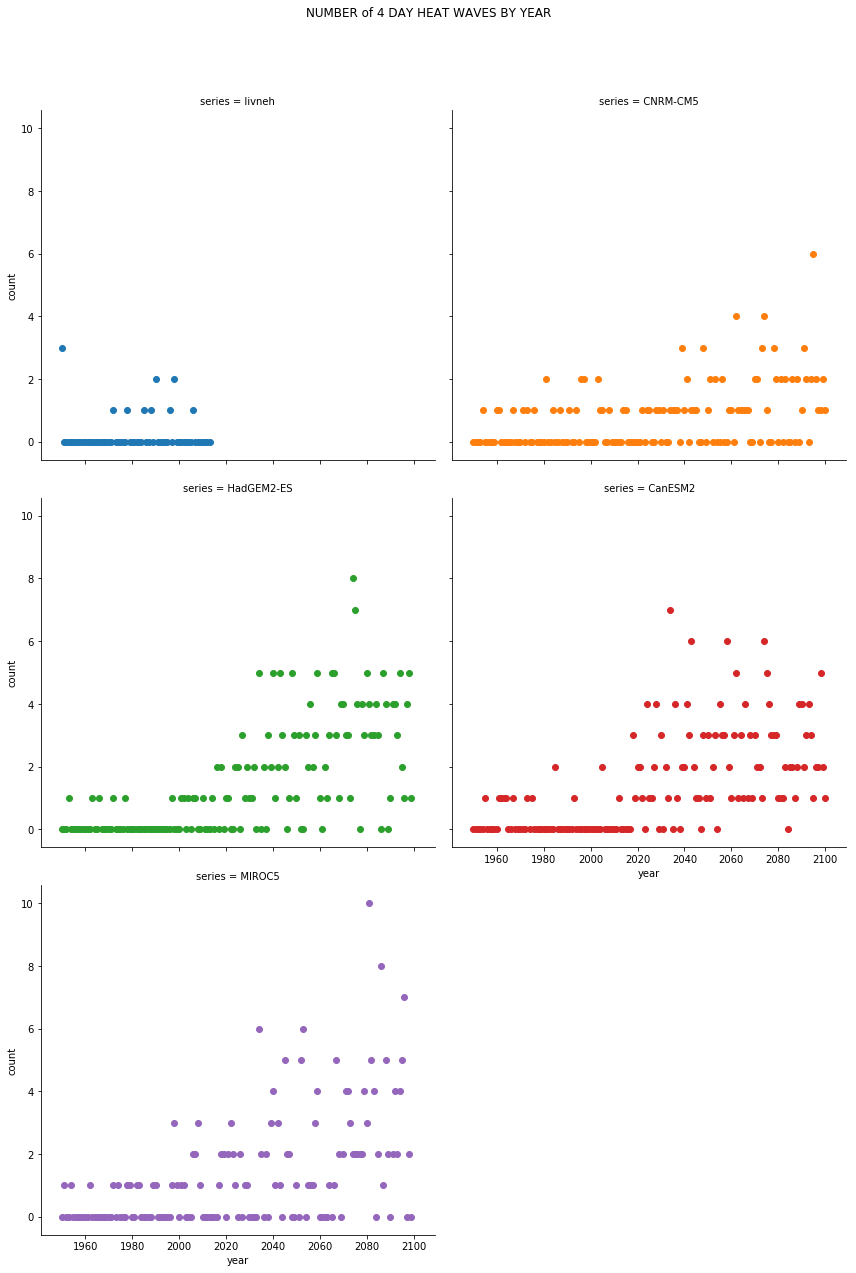

In [123]:
g = sns.FacetGrid(data=heat_waves, col='series', col_wrap=2, hue='series', size=6)
g.map(plt.scatter, 'year', 'count')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('NUMBER of 4 DAY HEAT WAVES BY YEAR')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


Text(0.5, 0.98, 'LONGEST STRETCH OF CONSECUTIVE EXTREME HEAT DAYS BY YEAR')

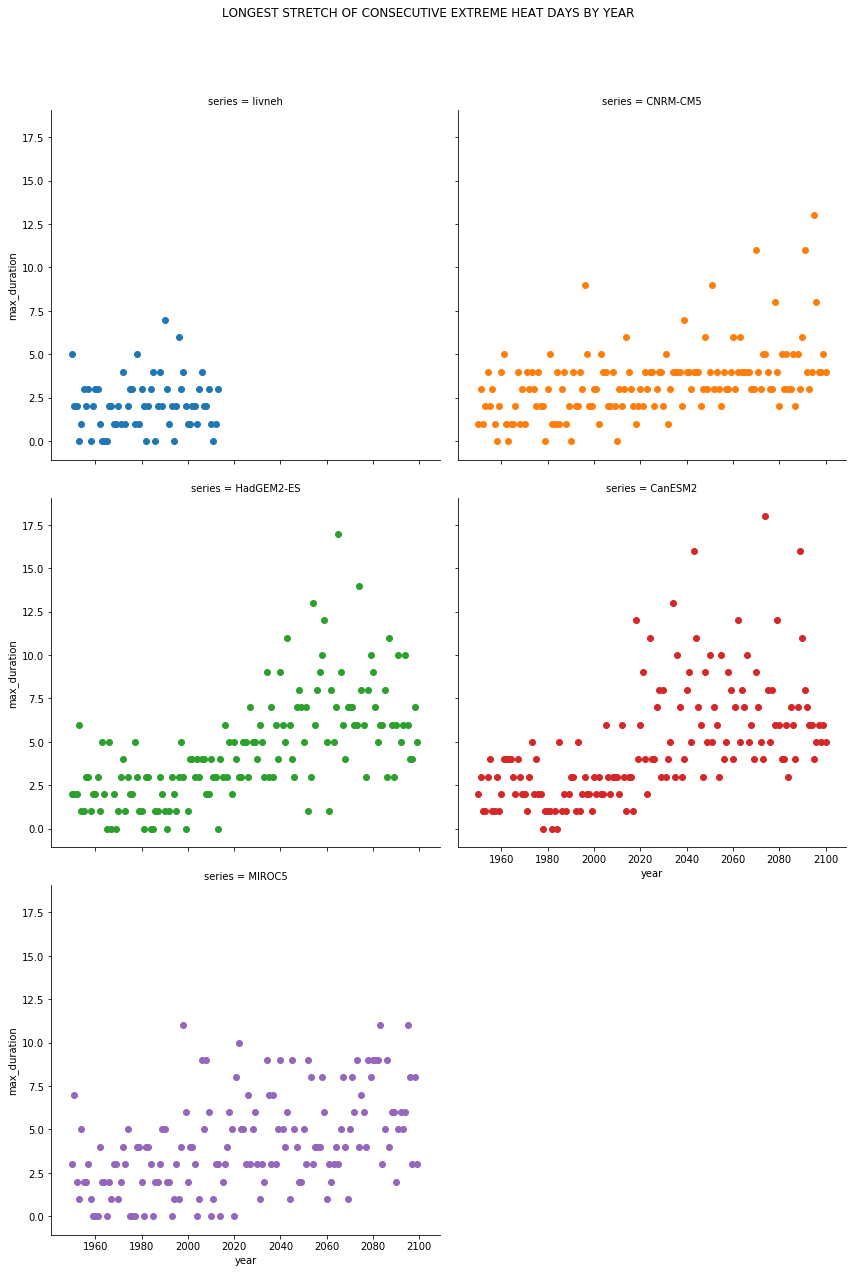

In [124]:
g = sns.FacetGrid(data=heat_waves, col='series', col_wrap=2, hue='series', size=6)
g.map(plt.scatter, 'year', 'max_duration')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('LONGEST STRETCH OF CONSECUTIVE EXTREME HEAT DAYS BY YEAR')